In [6]:
import pandas as pd
import json 
from langdetect import detect

In [7]:
d = json.load(open('data.json'))
df = pd.DataFrame(d)
df.to_excel('data_excel.xlsx')

In [8]:
df['is-en'] = df.text.apply(lambda x: detect(x) if len(x)>2 else 'none')
df = df[df['is-en']=='en']

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

In [10]:
emotions = []
for i in df.points.tolist():
    for item in i:
        emotions.append(item['emotion'])
    

In [11]:
from collections import Counter
emo = pd.DataFrame.from_dict(Counter(emotions), orient='index').reset_index().rename({0: 'count'}, axis=1).sort_values(by='count', ascending=False)

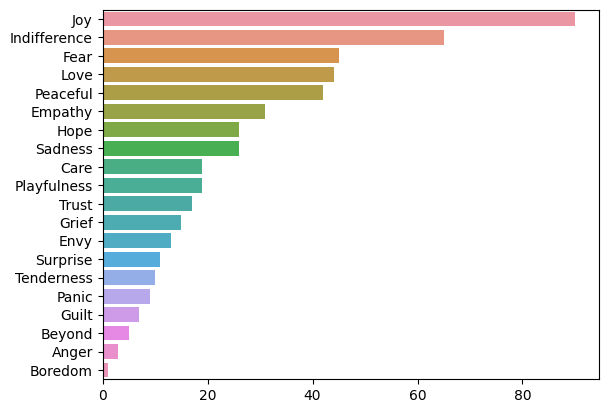

In [12]:
sns.barplot(data=emo, y='index', x='count')
plt.xlabel('')
plt.ylabel('')
plt.savefig('emotions.png', dpi=200)

### Word clouds

In [13]:
import spacy
all_words = ' '.join(df.text.tolist()).lower()
nlp = spacy.load('en_core_web_sm')
lemmas = []
for token in nlp(all_words):
    lemmas.append(token.lemma_)
lemmas = [l for l in lemmas if (len(l)>3 and l not in ['that', 'this', 'with', 'from',
                                                       'will', 'have', 'your', 'what',
                                                       'where', 'how', 'want', 'future', 'remember'])] # or (l in ['I', 'you', 'we',
                                                                         #         'us', 'it'])]
# make wordcloud

In [14]:
freq = pd.DataFrame.from_dict(Counter(lemmas), orient='index').reset_index().rename({0: 'count'}, axis=1).sort_values(by='count', ascending=False)

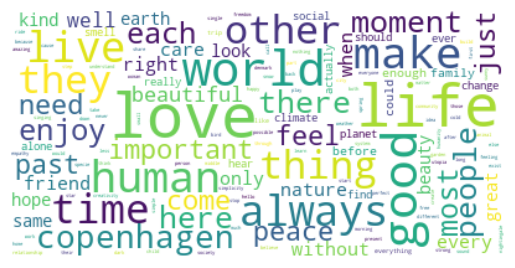

In [15]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="white",max_font_size=50, max_words=200).generate_from_frequencies(Counter(lemmas))
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('figures/wordcloud_filtered.png')


### Sementic space: sentence-level

In [16]:
from transformers import DistilBertTokenizer, DistilBertModel
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#tokenizer = DistilBertTokenizer.from_pretrained('bert-base-multilingual-cased')
#model = DistilBertModel.from_pretrained("bert-base-multilingual-cased")
#outputs = []
#for t in df['text'].tolist():
#    encoded_input = tokenizer(t, return_tensors='pt')
#    outputs.append(model(**encoded_input).last_hidden_state[0,0,:].detach().numpy().tolist())
# df['bert-vector'] = outputs
df['bert-vector'] = [model.encode(x) for x in df['text']]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import numpy as np
def _arraify(d, colname):
    return np.vstack([r for r in d[colname].tolist()])

In [19]:
import fasttext
ft = fasttext.load_model('models/wiki.en.bin')
df[f'fasttext-vec'] = [ft.get_sentence_vector(str(x).replace('\n','')) 
                       for x in df['text'].str.lower().str.strip().tolist()]

In [20]:
df['primary-emo'] = df['points'].apply(lambda x: x[0]['emotion'])

In [21]:
import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_neighbors=10, min_dist=0.01)

import plotly.express as px
projections = reducer.fit_transform(StandardScaler().fit_transform(_arraify(df, 'bert-vector')))
fig = px.scatter(
    projections, 
    x=0, y=1,
    width=1400, height=800,
    hover_data=[df['text']],
    labels={'0': '', '1': ''},
    color_discrete_sequence=['indianred']
)
fig.update_layout(
    template='plotly_white'
)
fig.update(layout_coloraxis_showscale=False)
fig.update_traces(hovertemplate="%{customdata[0]}")
fig.write_html("figures/statements_space_filtered.html")
fig.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

### Semantic space: word-level

In [22]:
wv = []
wdf = pd.DataFrame(zip(Counter(lemmas).keys(), Counter(lemmas).values()), columns=['words', 'freqs'])
for w in Counter(lemmas).keys():
     wv.append(ft.get_sentence_vector(w.replace('\n','')))
wdf['vec'] = wv     


In [23]:
import umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_neighbors=10, min_dist=0.05)

import plotly.express as px
projections = reducer.fit_transform(StandardScaler().fit_transform(_arraify(wdf, 'vec')))
fig = px.scatter(
    projections, 
    x=0, y=1,
    size=wdf['freqs'], 
    color=wdf['freqs'],
    width=1400, height=800,
    hover_data={'words': wdf['words']},
    labels={'0': '', '1': ''}
    #labels={'color': 'EU attachment'}
)
fig.update_layout(
    template='plotly_white'
)
fig.update(layout_coloraxis_showscale=False)
fig.update_traces(hovertemplate="%{customdata[0]}")
fig.write_html("figures/words_space_filtered.html")
fig.show()